In [0]:
import pandas as pd
import numpy as np
import io

url = 'https://raw.githubusercontent.com/metalhacker/Temp/master/Baltimore_Crime_Data.csv'
pd.set_option('display.max_columns', None)
df = pd.read_csv(url)
print(df.head)

<bound method NDFrame.head of          CrimeDate CrimeTime CrimeCode               Location  \
0       09/02/2017  23:30:00       3JK        4200 AUDREY AVE   
1       09/02/2017  23:00:00        7A      800 NEWINGTON AVE   
2       09/02/2017  22:53:00        9S          600 RADNOR AV   
3       09/02/2017  22:50:00        4C         1800 RAMSAY ST   
4       09/02/2017  22:31:00        4E           100 LIGHT ST   
...            ...       ...       ...                    ...   
276524  01/01/2012  00:00:00        6J           1400 JOH AVE   
276525  01/01/2012  00:00:00        6J       5500 SINCLAIR LN   
276526  01/01/2012  00:00:00        6E  400 N PATTERSON PK AV   
276527  01/01/2012  00:00:00        5A        5800 LILLYAN AV   
276528  01/01/2012  00:00:00        5A      1900 GRINNALDS AV   

                Description Inside/Outside   Weapon   Post      District  \
0       ROBBERY - RESIDENCE              I    KNIFE  913.0      SOUTHERN   
1                AUTO THEFT          

##Data Clearing and Manipulation

1. All Inside/Otside data are set to either Inside or Outside instead of abbreviations

2. Empty fields are set to N/A

3. CrimeDate is set to datetime type

4. For the premise column, records with a count less than 2000 are generalized to 'ALL OTHER'

In [0]:
df['Inside/Outside'] = df['Inside/Outside'].replace('I','Inside')
df['Inside/Outside'] = df['Inside/Outside'].replace('O','Outside')
df = df.fillna('N/A')
df['CrimeDate']=pd.to_datetime(df['CrimeDate'])
df['DayOfWeek']=df['CrimeDate'].dt.day_name()
df['Premise']=df['Premise'].str.upper()
premise = df['Premise'].value_counts()
for p, pcount in premise.iteritems():
    if pcount < 2000:
        df['Premise'] = df['Premise'].replace(p, 'ALL OTHER')

In [0]:
df.head()

,CrimeDate,CrimeTime,CrimeCode,Location,Description,Inside/Outside,Weapon,Post,District,Neighborhood,Longitude,Latitude,Location 1,Premise,Total Incidents,DayOfWeek
0,2017-09-02,23:30:00,3JK,4200 AUDREY AVE,ROBBERY - RESIDENCE,Inside,KNIFE,913,SOUTHERN,Brooklyn,-76.6054,39.2295,"(39.2295100000, -76.6054100000)",ROW/TOWNHO,1,Saturday
1,2017-09-02,23:00:00,7A,800 NEWINGTON AVE,AUTO THEFT,Outside,N/A,133,CENTRAL,Reservoir Hill,-76.6322,39.3136,"(39.3136000000, -76.6321700000)",STREET,1,Saturday
2,2017-09-02,22:53:00,9S,600 RADNOR AV,SHOOTING,Outside,FIREARM,524,NORTHERN,Winston-Govans,-76.607,39.3477,"(39.3476800000, -76.6069700000)",STREET,1,Saturday
3,2017-09-02,22:50:00,4C,1800 RAMSAY ST,AGG. ASSAULT,Inside,OTHER,934,SOUTHERN,Carrollton Ridge,-76.6453,39.2831,"(39.2831500000, -76.6452600000)",ROW/TOWNHO,1,Saturday
4,2017-09-02,22:31:00,4E,100 LIGHT ST,COMMON ASSAULT,Outside,HANDS,113,CENTRAL,Downtown West,-76.6137,39.2876,"(39.2875600000, -76.6136500000)",STREET,1,Saturday


##Data Visualization

###Count of crime for each district

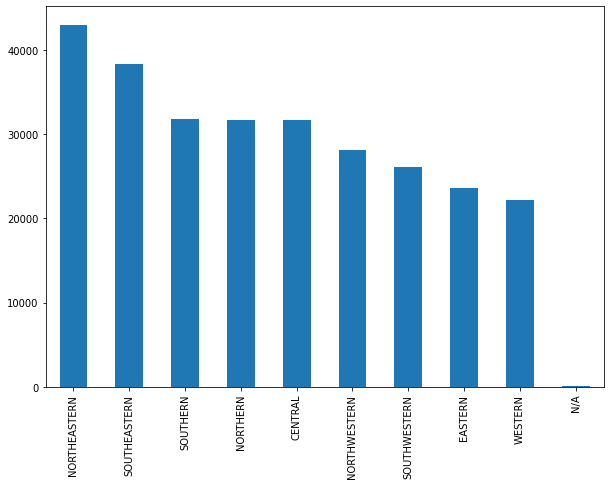

In [0]:
df['District'].value_counts().plot(kind='bar', figsize=(10,7))

###Portion of each weapon type used in all kinds of crimes

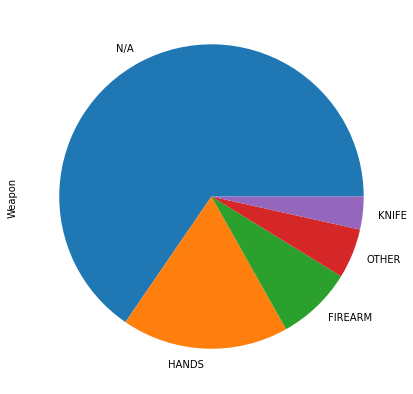

In [0]:
df['Weapon'].value_counts().plot(kind='pie', figsize=(7,7))

###Place of crime, Inside/Outside

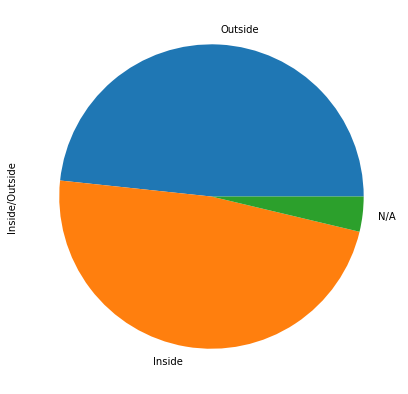

In [0]:
df['Inside/Outside'].value_counts().plot(kind='pie', figsize=(7,7))

###Total number of crimes amoung different years.

2017 is significantly less due to the data was collected before end of 2017.

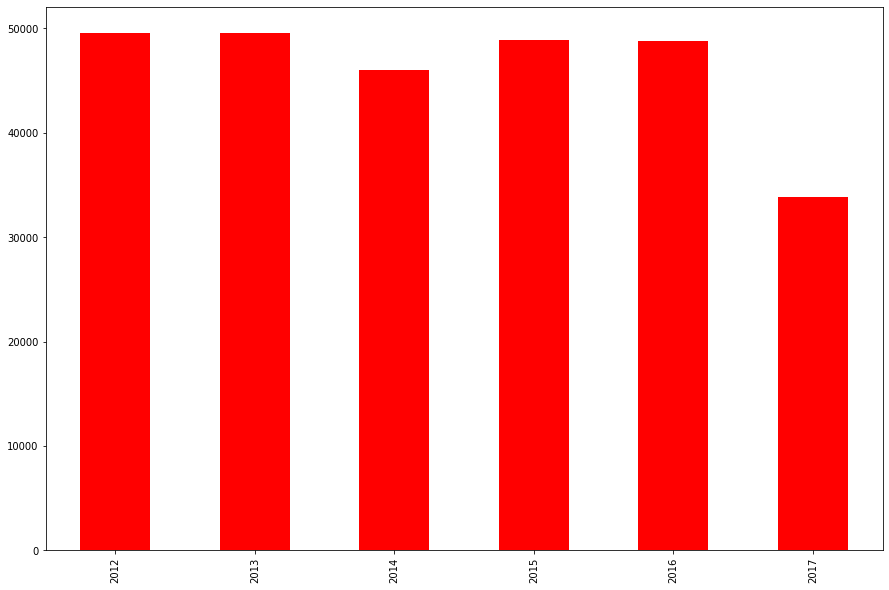

In [0]:
df['CrimeDate'].dt.year.value_counts().sort_index().plot(kind = 'bar', figsize = (15, 10), color = 'red')

###Line chart for time in a day

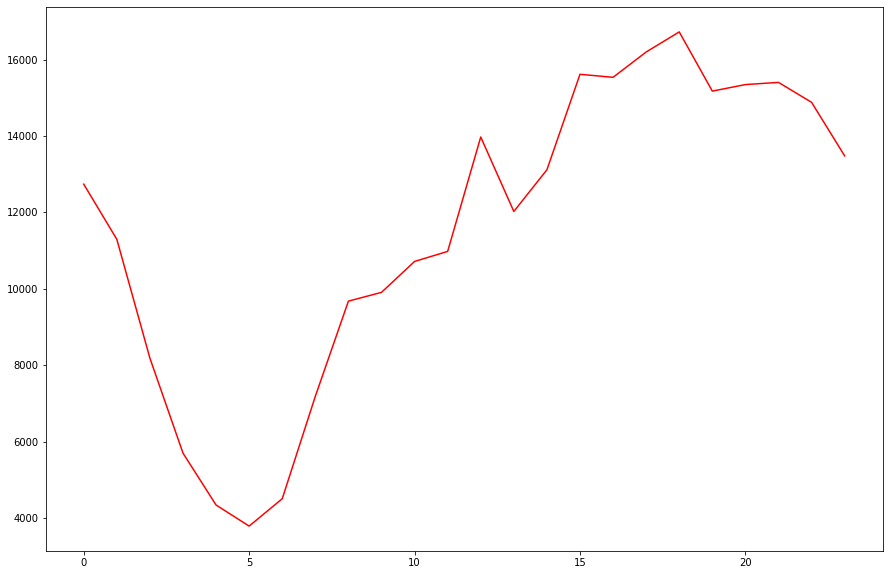

In [0]:
df['CrimeTime'] = df['CrimeTime'].replace('24:00:00','00:00:00')
df[['hour', 'minute', 'second']] = df['CrimeTime'].astype(str).str.split(':', expand=True).astype(int)
df['hour'].value_counts().sort_index().plot(kind = 'line', figsize = (15, 10), color = 'red')

###Analysis by premise

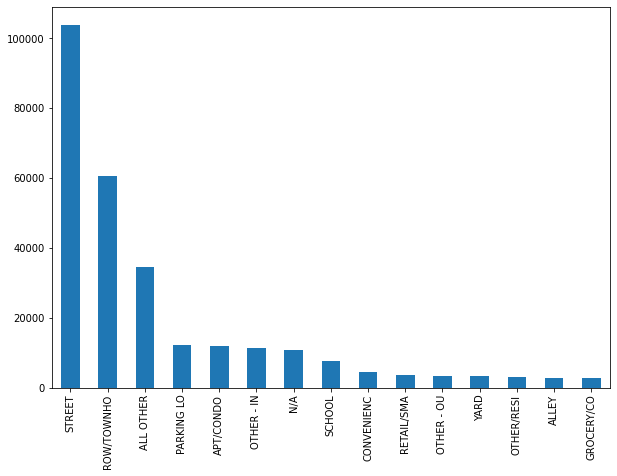

In [0]:
df['Premise'].value_counts().plot(kind='bar', figsize=(10,7))

###Plot crimes on map

In [0]:
import folium as fl
from folium import plugins
from folium.plugins import HeatMap

balt_geo_url = 'https://raw.githubusercontent.com/metalhacker/Temp/master/bpd_districts.geojson'
balt_geo = f'{balt_geo_url}'
crime_map = fl.Map(location=[39.3, -76.6], zoom_start = 12)

#Prepare a df of count of crimes by district
district_count = pd.DataFrame(df['District'].value_counts())
district_count.reset_index(inplace = True)
district_count.rename(columns = {'District': 'Count', 'index': 'District'}, inplace = True)
district_count = district_count[district_count['District'] != 'N/A']    #N/A is dropped
district_count['District'] = district_count['District'].str.title()

fl.Choropleth(
    geo_data = balt_geo,
    data = district_count,
    columns = ['District', 'Count'],
    key_on='feature.properties.name',
    fill_color = 'YlOrRd',
    fill_opacity = 0.7,
    line_opacity = 0.2,
    highlight = True,
    legend_name = 'Baltimore Crime Map'
).add_to(crime_map)

pd_location_url = 'https://raw.githubusercontent.com/metalhacker/Temp/master/bpd_station_data.csv'
pd_location_df = pd.read_csv(pd_location_url)
pd_location_y = list(pd_location_df['Longitude'])
pd_location_x = list(pd_location_df['Latitude'])

for x,y in zip(pd_location_x,pd_location_y):
    fl.Marker([x, y], popup='Police Station').add_to(crime_map)

crime_map

##Apply Classification algorithms (PyWeka)

###Data preparation

First, install weka python wrapper

In [0]:
import os
import sys
sys.path
sys.path.append("/usr/lib/jvm/java-11-openjdk-amd64/bin/")
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64/"
!apt update
!apt-get install build-essential python3-dev
!apt-get install python3-pil python3-pygraphviz
!apt install openjdk-11-jdk
!pip3 install javabridge --no-cache-dir
!pip3 install python-weka-wrapper3 --no-cache-dir
!pip install arff
import weka.core.jvm as jvm
jvm.start()

Ign:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran35/ InRelease [3,626 B]
Hit:3 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:4 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:5 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease [21.3 kB]
Ign:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:10 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran35/ Packages [91.7 kB]
Get:11 http://ppa.launchpad.net/marutter/c2d4u3.5/ubuntu bionic InRelease [15.4 kB]
Get:12 http://archive.ubuntu.com/ubuntu bionic-backports InRelea

DEBUG:weka.core.jvm:Adding bundled jars
DEBUG:weka.core.jvm:Classpath=['/usr/local/lib/python3.6/dist-packages/javabridge/jars/rhino-1.7R4.jar', '/usr/local/lib/python3.6/dist-packages/javabridge/jars/runnablequeue.jar', '/usr/local/lib/python3.6/dist-packages/javabridge/jars/cpython.jar', '/usr/local/lib/python3.6/dist-packages/weka/lib/weka.jar', '/usr/local/lib/python3.6/dist-packages/weka/lib/python-weka-wrapper.jar']
DEBUG:weka.core.jvm:MaxHeapSize=default
DEBUG:weka.core.jvm:Package support disabled


Then fetch and load the data.

In [0]:
df_for_arff = df.drop(['CrimeDate', 'CrimeTime', 'second', 'minute','Longitude','Latitude','Location 1','Post','CrimeCode','Total Incidents','Neighborhood','Location'], axis = 1)
df_for_arff = df_for_arff.replace('N/A', '?')
import arff
arff.dump('baltimore_crime_processed.arff'
      , df_for_arff.values
      , relation='transform'
      , names=df_for_arff.columns)
print(df_for_arff.head())

from weka.core.converters import Loader
from weka.core.classes import Random
loader = Loader(classname="weka.core.converters.ArffLoader")
raw_data = loader.load_file("baltimore_crime_processed.arff")
raw_data.class_index = 4 #set weapon to class index

from weka.filters import Filter

replace = Filter(classname="weka.filters.unsupervised.attribute.StringToNominal", options=["-R", "1,2,3,4,5,6"])
replace.inputformat(raw_data)
raw_data = replace.filter(raw_data)
print(replace.to_source("MyReplaceString", raw_data))
train, test = raw_data.train_test_split(66.6, Random(1))

           Description Inside/Outside   Weapon  District     Premise  \
0  ROBBERY - RESIDENCE         Inside    KNIFE  SOUTHERN  ROW/TOWNHO   
1           AUTO THEFT        Outside        ?   CENTRAL      STREET   
2             SHOOTING        Outside  FIREARM  NORTHERN      STREET   
3         AGG. ASSAULT         Inside    OTHER  SOUTHERN  ROW/TOWNHO   
4       COMMON ASSAULT        Outside    HANDS   CENTRAL      STREET   

  DayOfWeek  hour  
0  Saturday    23  
1  Saturday    23  
2  Saturday    22  
3  Saturday    22  
4  Saturday    22  
None


###Using weka decision tree (J48)

In [0]:
from weka.classifiers import Classifier, Evaluation, PredictionOutput
J48 = Classifier(classname="weka.classifiers.trees.J48")
J48.set_property("minNumObj", 500)
J48.build_classifier(train)
print(J48)

output = PredictionOutput(classname="weka.classifiers.evaluation.output.prediction.CSV", options=["-distribution"])
evl = Evaluation(train)
evl.test_model(J48, test, output=output)
print(evl.summary())

J48 pruned tree
------------------

Inside/Outside = Inside
|   Description = ROBBERY - RESIDENCE: ROW/TOWNHO (1721.0/458.0)
|   Description = AUTO THEFT: ROW/TOWNHO (1252.0/748.0)
|   Description = SHOOTING: ALL OTHER (209.0/83.0)
|   Description = AGG. ASSAULT: ROW/TOWNHO (8508.0/3481.0)
|   Description = COMMON ASSAULT: ROW/TOWNHO (18554.0/8222.0)
|   Description = BURGLARY: ROW/TOWNHO (26070.0/9975.0)
|   Description = HOMICIDE: ALL OTHER (202.0/48.0)
|   Description = ROBBERY - STREET: ALL OTHER (1114.0/733.0)
|   Description = ROBBERY - COMMERCIAL
|   |   hour <= 9: CONVENIENC (565.0/279.0)
|   |   hour > 9: ALL OTHER (1707.0/1003.0)
|   Description = LARCENY
|   |   District = SOUTHERN
|   |   |   hour <= 8: ROW/TOWNHO (542.0/383.0)
|   |   |   hour > 8: ALL OTHER (2217.0/1580.0)
|   |   District = CENTRAL: ALL OTHER (3874.0/2137.0)
|   |   District = NORTHERN
|   |   |   hour <= 10: ROW/TOWNHO (854.0/596.0)
|   |   |   hour > 10: ALL OTHER (2316.0/1674.0)
|   |   District = SOU

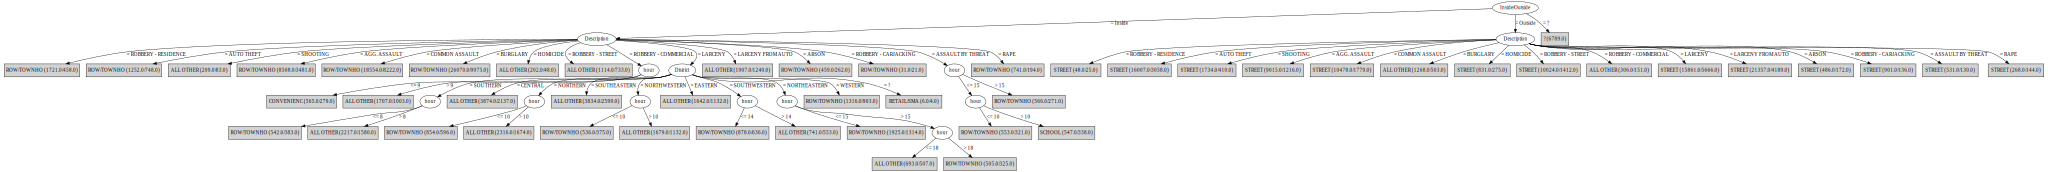

In [0]:
import pydotplus
from IPython.display import SVG

J48tree = pydotplus.graph_from_dot_data(J48.graph)
J48tree.set_size('"50,50!"')

SVG(J48tree.create_svg())

###Using weka rule based classifier (OneR)

In [0]:
OneR = Classifier(classname="weka.classifiers.rules.OneR")
OneR.build_classifier(train)
print(OneR)

output = PredictionOutput(classname="weka.classifiers.evaluation.output.prediction.CSV", options=["-distribution"])
evl = Evaluation(train)
evl.test_model(OneR, test, output=output)
print(evl.summary())

Inside/Outside:
	Inside	-> ROW/TOWNHO
	Outside	-> STREET
	?	-> ?
(116287/184168 instances correct)


Correctly Classified Instances       58193               63.006  %
Incorrectly Classified Instances     34168               36.994  %
Kappa statistic                          0.4813
Mean absolute error                      0.0493
Root mean squared error                  0.2221
Relative absolute error                 47.0086 %
Root relative squared error             96.9081 %
Total Number of Instances            92361     



###Using weka rule based classifier (JRip)

In [0]:
JRip = Classifier(classname="weka.classifiers.rules.JRip")
JRip.set_property("minNo", 50.0)
JRip.build_classifier(train)
print(JRip)

output = PredictionOutput(classname="weka.classifiers.evaluation.output.prediction.CSV", options=["-distribution"])
evl = Evaluation(train)
evl.test_model(JRip, test, output=output)
print(evl.summary())

JRIP rules:

(Inside/Outside = Inside) and (Description = ROBBERY - COMMERCIAL) and (hour <= 4) and (hour >= 2) => Premise=CONVENIENC (181.0/48.0)
(Inside/Outside = ?) => Premise=? (6789.0/0.0)
(Inside/Outside = Inside) and (Description = LARCENY) and (District = CENTRAL) and (DayOfWeek = Thursday) and (hour <= 19) and (hour >= 10) => Premise=ALL OTHER (381.0/175.0)
(Inside/Outside = Inside) and (Description = LARCENY) and (District = CENTRAL) and (DayOfWeek = Saturday) => Premise=ALL OTHER (597.0/297.0)
(Inside/Outside = Inside) and (Description = BURGLARY) and (hour <= 16) and (hour >= 7) and (District = SOUTHEASTERN) => Premise=ROW/TOWNHO (1673.0/344.0)
(Inside/Outside = Inside) and (Description = BURGLARY) and (hour <= 15) and (hour >= 6) and (District = NORTHEASTERN) => Premise=ROW/TOWNHO (2723.0/690.0)
(Inside/Outside = Inside) and (Description = BURGLARY) and (hour >= 6) and (hour <= 15) and (District = SOUTHWESTERN) => Premise=ROW/TOWNHO (1460.0/403.0)
(Inside/Outside = Inside)

###Using weka naive bayes

In [0]:
NB = Classifier(classname='weka.classifiers.bayes.NaiveBayes')
NB.build_classifier(train)
print(NB)

output = PredictionOutput(classname="weka.classifiers.evaluation.output.prediction.CSV", options=["-distribution"])
evl = Evaluation(train)
evl.test_model(NB, test, output=output)
print(evl.summary())

Naive Bayes Classifier

                              Class
Attribute                ROW/TOWNHO     STREET RETAIL/SMA          ?       YARD OTHER - IN CONVENIENC  ALL OTHER  APT/CONDO PARKING LO      ALLEY GROCERY/CO OTHER - OU     SCHOOL OTHER/RESI
                             (0.22)     (0.38)     (0.01)     (0.04)     (0.01)     (0.04)     (0.02)     (0.13)     (0.04)     (0.04)     (0.01)     (0.01)     (0.01)     (0.03)     (0.01)
Description
  ROBBERY - RESIDENCE         1264.0       24.0        3.0       74.0        6.0       36.0        2.0       75.0      318.0        7.0        2.0        1.0        6.0        3.0       36.0
  AUTO THEFT                   505.0    12950.0        9.0      604.0      321.0      113.0       10.0      963.0       88.0     1755.0      299.0        4.0      200.0       36.0       20.0
  SHOOTING                       1.0     1385.0        1.0      148.0        1.0        1.0        1.0      274.0        1.0       61.0       80.0        1.0        1

##Apply Classification algorithms (sklearn)

###Process raw data

Since sklearn classifiers require data to be neumerical float points, we need to transform data from categorical string type to float type using encoders

In [0]:
processed_df = df.drop(['CrimeDate', 'CrimeTime', 'second', 'minute','Longitude','Latitude','Location 1','Post','CrimeCode'], axis = 1)
X = processed_df.drop(['Premise'], axis = 1)
y = processed_df['Premise']
X['Total Incidents'] = X['Total Incidents'].astype(str)
X['hour'] = X['hour'].astype(str)

from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder

oe = OrdinalEncoder()
oe.fit(X)
X_encoded = oe.transform(X)

le = LabelEncoder()
le.fit(y)
y_encoded = le.transform(y)

###Using sklearn decision tree (CART)

To use sklearn decision tree, we need to first process all data in to ordinal numerical values since that sklearn does not support categorical decision tree.

Yet we can still extract the data by decoding it.

Accuracy of sklearn decision tree is: 0.6552694332334743


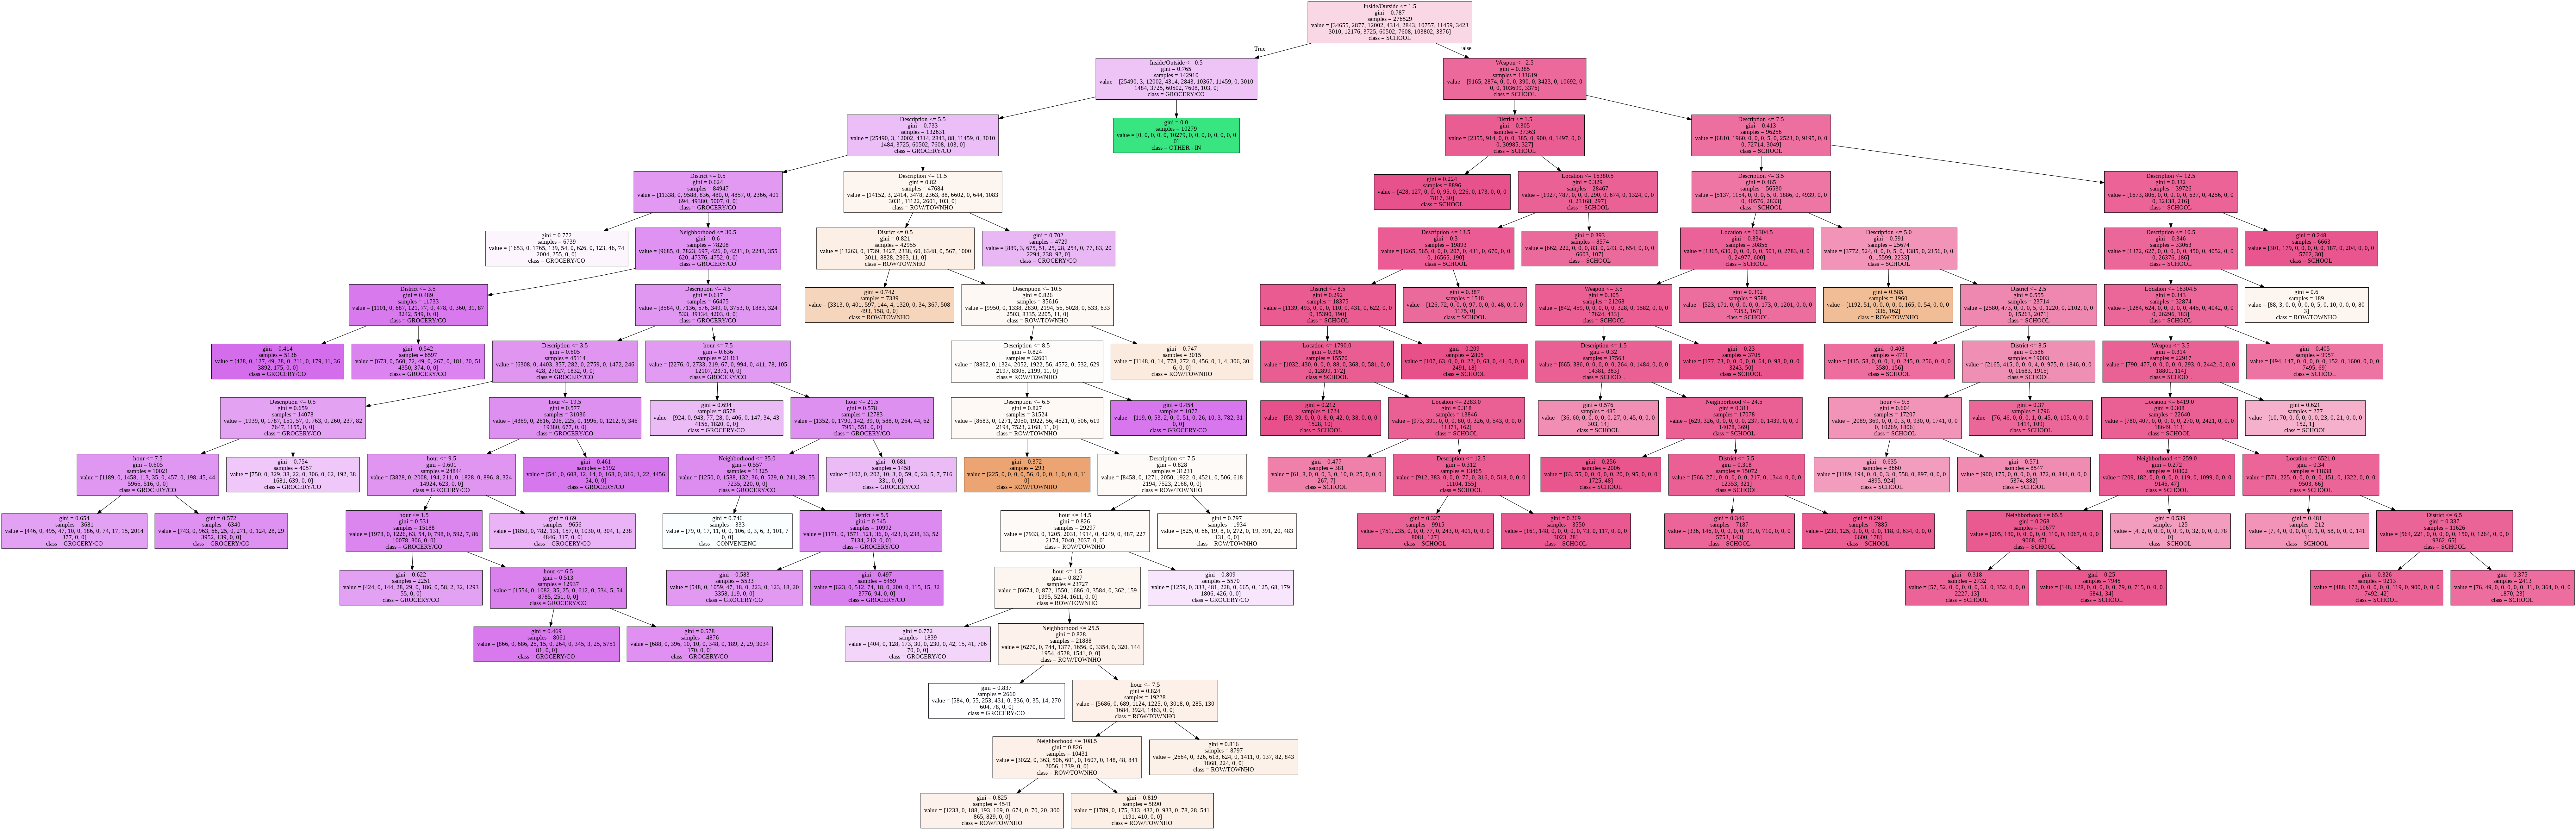

In [0]:
from sklearn import tree
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import matplotlib.pyplot as plt
dt = DecisionTreeClassifier(min_samples_split = 10000)
dt = dt.fit(X_encoded, y_encoded)

print("Accuracy of sklearn decision tree is:", cross_val_score(dt, X_encoded, y_encoded, cv = 10, scoring = 'accuracy').mean())

import graphviz
import pydotplus
from IPython.display import display,Image
dt_feature_names = list(X.columns)
dt_target_names = [str(s) for s in y.unique()]
tree.export_graphviz(dt, out_file='tree.dot', 
    feature_names=dt_feature_names, class_names=dt_target_names,
    filled=True)  
graph = pydotplus.graph_from_dot_file('tree.dot')
Image(graph.create_png())

###Using sklearn knn

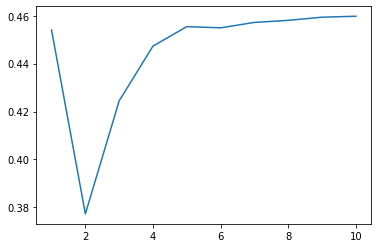

In [0]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics

X_train, X_test, y_train, y_test = train_test_split(X_encoded, y_encoded, test_size = 0.33, random_state = 42)
k_range = range(1,11)
knn_scores = {}
knn_scores_list = []

for k in k_range:
    neigh = KNeighborsClassifier(n_neighbors=k)
    neigh.fit(X_train, y_train)
    y_pred = neigh.predict(X_test)
    knn_scores[k] = metrics.accuracy_score(y_test, y_pred)
    knn_scores_list.append(metrics.accuracy_score(y_test, y_pred))

plt.plot(k_range, knn_scores_list)